# Comprehensive Model Comparison: Standard Transformer vs Diff Transformer vs Hymba vs Mamba

This notebook provides an in-depth comparison of four state-of-the-art architectures:

1. **Standard Transformer** - Baseline with modern improvements (RMSNorm, RoPE, GQA)
2. **Diff Transformer** - Differential attention mechanism
3. **Hymba** - Hybrid architecture (Attention + Mamba) with SWA and KV sharing
4. **Mamba** - Pure selective state space model

## Key Features:
- **Parameter Balancing**: All models tuned to have similar parameter counts
- **Attention Visualization**: Compare attention patterns across transformer variants
- **Comprehensive Metrics**: Training efficiency, inference speed, memory usage, quality

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import math
import gc
from contextlib import nullcontext
from IPython.display import display, HTML

# ===================== GPU Selection =====================
GPU_ID = None  # Change to 0, 1, 2, etc.

if GPU_ID is not None and torch.cuda.is_available():
    if GPU_ID < torch.cuda.device_count():
        device = f"cuda:{GPU_ID}"
        torch.cuda.set_device(GPU_ID)
        print(f"Using GPU {GPU_ID}: {torch.cuda.get_device_name(GPU_ID)}")
    else:
        print(f"Warning: GPU {GPU_ID} not available. Available GPUs: {torch.cuda.device_count()}")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Falling back to: {device}")
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

# ===================== VRAM Management Utilities =====================
def get_gpu_memory_info():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3)  # GB
        reserved = torch.cuda.memory_reserved() / (1024**3)  # GB
        return allocated, reserved
    return 0, 0

def clear_memory():
    """Clear GPU memory and run garbage collection"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def print_memory_status(label=""):
    """Print current memory status with optional label"""
    alloc, reserved = get_gpu_memory_info()
    if label:
        print(f"[Memory] {label}: {alloc:.2f}GB alloc, {reserved:.2f}GB reserved")
    else:
        print(f"[Memory] {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")

# ===================== Modern Visualization Utilities =====================
def set_modern_style():
    """Set modern, clean visualization style"""
    plt.style.use('default')
    sns.set_palette("husl")
    plt.rcParams.update({
        'figure.figsize': (14, 8),
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'font.family': 'sans-serif',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
    })

set_modern_style()

# Print initial memory status
alloc, reserved = get_gpu_memory_info()
print(f"\n{'='*70}")
print(f"{'🚀 Comprehensive Model Comparison Framework':^70}")
print(f"{'='*70}")
print(f"Device: {device}")
print(f"Initial VRAM: {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")
print(f"{'='*70}\n")

Using device: cuda
Available GPUs: 6
  GPU 0: NVIDIA A100 80GB PCIe
  GPU 1: NVIDIA A100 80GB PCIe
  GPU 2: NVIDIA A100 80GB PCIe
  GPU 3: NVIDIA A100 80GB PCIe
  GPU 4: NVIDIA A100 80GB PCIe
  GPU 5: NVIDIA A100 80GB PCIe

              🚀 Comprehensive Model Comparison Framework              
Device: cuda
Initial VRAM: 0.00GB allocated, 0.00GB reserved



## 1. Model Imports

In [2]:
# Import all models
from backbone.standard_transformer import StandardTransformer, ModelCfg as StdCfg, TrainCfg
from backbone.diff_transformer import DiffTransformer, ModelCfg as DiffCfg
from backbone.hymba_v2 import HymbaV2, ModelCfg as HymbaCfg, build_everything as build_hymba
from backbone.mamba_model import MambaModel, ModelCfg as MambaCfg

print("All models imported successfully!")

2025-10-22 05:36:43.909510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 05:36:44.461795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


All models imported successfully!


## 2. Parameter Balancing

We carefully tune each model's architecture to achieve similar parameter counts for fair comparison.

In [3]:
# ===================== Configuration Presets =====================
# Choose a preset configuration:
# - "small": Fast testing with small models (current default)
# - "medium": Balanced comparison (~10M params, 512 seq_len)
# - "large": Large-scale comparison (~30M params, 1024 seq_len)

CONFIG_PRESET = "large"  # Change to "medium" or "large" for bigger tests

if CONFIG_PRESET == "small":
    # Small: Fast testing and visualization
    SEQ_LEN = 256
    BATCH_SIZE = 32
    VOCAB_SIZE = 5000
    STEPS = 500
    
    # Model sizes (~2-8M params, balanced for small-scale testing)
    std_d_model, std_n_layers = 256, 6
    diff_d_model, diff_n_layers = 256, 5
    hymba_d_model, hymba_n_layers = 256, 6
    mamba_d_model, mamba_n_layers = 320, 6  # ~6M params
    
elif CONFIG_PRESET == "medium":
    # Medium: Realistic comparison (~20-24M params)
    SEQ_LEN = 512
    BATCH_SIZE = 24
    VOCAB_SIZE = 8000
    STEPS = 1000
    
    # Model sizes balanced around ~23M params
    std_d_model, std_n_layers = 384, 8
    diff_d_model, diff_n_layers = 384, 7
    hymba_d_model, hymba_n_layers = 384, 8
    mamba_d_model, mamba_n_layers = 608, 8  # ~24M params (matching others)
    
elif CONFIG_PRESET == "large":
    # Large: Full-scale comparison (~50-56M params, requires significant VRAM)
    SEQ_LEN = 1024
    BATCH_SIZE = 16
    VOCAB_SIZE = 10000
    STEPS = 2000
    
    # Model sizes balanced around ~55M params
    std_d_model, std_n_layers = 512, 12
    diff_d_model, diff_n_layers = 512, 10
    hymba_d_model, hymba_n_layers = 512, 12
    mamba_d_model, mamba_n_layers = 768, 12  # ~53M params (matching others)

else:
    raise ValueError(f"Unknown CONFIG_PRESET: {CONFIG_PRESET}")

print(f"Configuration Preset: {CONFIG_PRESET.upper()}")
print(f"  SEQ_LEN={SEQ_LEN}, BATCH_SIZE={BATCH_SIZE}, VOCAB_SIZE={VOCAB_SIZE}")
print(f"  STEPS={STEPS}")
print(f"  Note: Using official mamba-ssm for efficient SSM operations")

# Training configuration
LR = 6e-4
WARMUP = int(STEPS * 0.2)

# Model-specific configs
# Standard Transformer
std_cfg = StdCfg(
    vocab_size=VOCAB_SIZE,
    d_model=std_d_model,
    n_layers=std_n_layers,
    n_heads=8,
    n_kv_heads=2,
    dropout=0.1,
    seq_len=SEQ_LEN
)

# Diff Transformer
diff_cfg = DiffCfg(
    vocab_size=VOCAB_SIZE,
    d_model=diff_d_model,
    n_layers=diff_n_layers,
    n_heads=8,
    n_kv_heads=2,
    dropout=0.1,
    seq_len=SEQ_LEN
)

# Hymba: balanced hybrid
hymba_cfg = HymbaCfg(
    vocab_size=VOCAB_SIZE,
    d_model=hymba_d_model,
    n_layers=hymba_n_layers,
    n_heads=8,
    n_kv_heads=2,
    dropout=0.1,
    seq_len=SEQ_LEN,
    swa_layers=tuple(range(1, hymba_n_layers-1)) if hymba_n_layers > 2 else (),
    swa_window=min(256, SEQ_LEN // 2)
)

# Mamba: d_model adjusted per preset to match other models' parameter count
mamba_cfg = MambaCfg(
    vocab_size=VOCAB_SIZE,
    d_model=mamba_d_model,
    n_layers=mamba_n_layers,
    state_size=16,
    d_conv=4,
    expand=2,
    dropout=0.1,
    seq_len=SEQ_LEN
)

print(f"\nModel Configurations:")
print(f"  Standard: d_model={std_d_model}, n_layers={std_n_layers}")
print(f"  Diff:     d_model={diff_d_model}, n_layers={diff_n_layers}")
print(f"  Hymba:    d_model={hymba_d_model}, n_layers={hymba_n_layers}")
print(f"  Mamba:    d_model={mamba_d_model}, n_layers={mamba_n_layers} (adjusted for similar param count)")

Configuration Preset: LARGE
  SEQ_LEN=1024, BATCH_SIZE=16, VOCAB_SIZE=10000
  STEPS=2000
  Note: Using official mamba-ssm for efficient SSM operations

Model Configurations:
  Standard: d_model=512, n_layers=12
  Diff:     d_model=512, n_layers=10
  Hymba:    d_model=512, n_layers=12
  Mamba:    d_model=768, n_layers=12 (adjusted for similar param count)


## 3. Build Data and Models

In [4]:
# Build data (using Hymba's build function for consistency)
print("Loading dataset...")
_, tok, train_dl, val_dl = build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)
print(f"Dataset ready: {len(train_dl)} train batches, {len(val_dl)} val batches")

Loading dataset...


Dataset ready: 16 train batches, 1 val batches


In [5]:
# Build models
models = {}
param_counts = {}

print("Building models...\n")

# Standard Transformer
print("1. Standard Transformer")
std_model = StandardTransformer(std_cfg).to(device)
std_params = sum(p.numel() for p in std_model.parameters() if p.requires_grad)
models['Standard'] = std_model
param_counts['Standard'] = std_params
print(f"   Parameters: {std_params:,}\n")

# Diff Transformer
print("2. Diff Transformer")
diff_model = DiffTransformer(diff_cfg).to(device)
diff_params = sum(p.numel() for p in diff_model.parameters() if p.requires_grad)
models['Diff'] = diff_model
param_counts['Diff'] = diff_params
print(f"   Parameters: {diff_params:,}\n")

# Hymba
print("3. Hymba (Hybrid)")
hymba_model = HymbaV2(hymba_cfg).to(device)
hymba_params = sum(p.numel() for p in hymba_model.parameters() if p.requires_grad)
models['Hymba'] = hymba_model
param_counts['Hymba'] = hymba_params
print(f"   Parameters: {hymba_params:,}")
display(hymba_model.layer_table())
print()

# Mamba
print("4. Mamba (SSM)")
mamba_model = MambaModel(mamba_cfg).to(device)
mamba_params = sum(p.numel() for p in mamba_model.parameters() if p.requires_grad)
models['Mamba'] = mamba_model
param_counts['Mamba'] = mamba_params
print(f"   Parameters: {mamba_params:,}\n")

# Summary
print("="*60)
print("Parameter Count Summary:")
for name, count in param_counts.items():
    print(f"  {name:15s}: {count:>10,} ({count/1e6:.2f}M)")
print("="*60)

Building models...

1. Standard Transformer
   Parameters: 55,865,856

2. Diff Transformer
   Parameters: 54,817,792

3. Hymba (Hybrid)
   Parameters: 55,867,904


,layer,attn,kv_owner,kv_share_group
0,0,GLOBAL,0,0
1,1,LOCAL(SWA),1,1
2,2,LOCAL(SWA),1,1
3,3,LOCAL(SWA),3,2
4,4,LOCAL(SWA),3,2
5,5,LOCAL(SWA),5,3
6,6,LOCAL(SWA),5,3
7,7,LOCAL(SWA),7,4
8,8,LOCAL(SWA),7,4
9,9,LOCAL(SWA),9,5



4. Mamba (SSM)
   Parameters: 52,940,544

Parameter Count Summary:
  Standard       : 55,865,856 (55.87M)
  Diff           : 54,817,792 (54.82M)
  Hymba          : 55,867,904 (55.87M)
  Mamba          : 52,940,544 (52.94M)


## 4. Training Functions

In [6]:
def train_model(model, train_dl, val_dl, model_name, steps=STEPS):
    """Train a model and return metrics"""
    # Import train_loop from the appropriate module
    if model_name == 'Standard':
        from backbone.standard_transformer import train_loop
    elif model_name == 'Diff':
        from backbone.diff_transformer import train_loop
    elif model_name == 'Hymba':
        from backbone.hymba_v2 import train_loop
    else:  # Mamba
        from backbone.mamba_model import train_loop
    
    tcfg = TrainCfg(
        seq_len=SEQ_LEN,
        batch_size=BATCH_SIZE,
        steps=steps,
        lr=LR,
        warmup=WARMUP,
        amp=True,
        grad_clip=1.0
    )
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    print_memory_status(f"Before training {model_name}")
    
    torch.cuda.reset_peak_memory_stats() if device == "cuda" else None
    start_time = time.time()
    
    stats = train_loop(model, train_dl, val_dl, tcfg, device=device)
    
    elapsed = time.time() - start_time
    peak_mem = torch.cuda.max_memory_allocated() / (1024**2) if device == "cuda" else 0.0
    
    stats['model'] = model_name
    stats['time_s'] = elapsed
    stats['params'] = param_counts[model_name]
    stats['peak_mem_mb'] = peak_mem
    
    print_memory_status(f"After training {model_name}")
    
    # Clear memory after training
    clear_memory()
    print_memory_status(f"After clearing cache")
    
    return stats

## 5. Evaluation Functions

In [7]:
@torch.no_grad()
def evaluate_ppl(model, val_dl, amp=True):
    """Evaluate perplexity on validation set"""
    model.eval()
    nll = 0.0
    tok_count = 0
    ctx = (torch.amp.autocast("cuda") if (amp and device=="cuda") else nullcontext())
    
    with ctx:
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb, targets=yb)
            nll += out["loss"].item() * xb.numel()
            tok_count += xb.numel()
    
    return math.exp(nll / max(1, tok_count))

@torch.no_grad()
def bench_generate(model, prompt_len=128, gen_len=128, warmup=1, repeat=3):
    """Benchmark generation speed"""
    model.eval()
    device_t = next(model.parameters()).device
    
    if hasattr(model, 'cfg'):
        vocab = model.cfg.vocab_size
    else:
        vocab = VOCAB_SIZE
    
    torch.manual_seed(42)
    prompt = torch.randint(0, vocab, (1, prompt_len), device=device_t)

    # Warmup
    for _ in range(warmup):
        try:
            _ = model.generate(prompt, max_new_tokens=16)
        except:
            pass

    if device_t.type == "cuda":
        torch.cuda.reset_peak_memory_stats()

    times = []
    for _ in range(repeat):
        if device_t.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()
        try:
            _ = model.generate(prompt, max_new_tokens=gen_len)
        except:
            pass
        if device_t.type == "cuda":
            torch.cuda.synchronize()
        times.append(time.time() - t0)

    sec = sum(times) / len(times)
    tps = int((prompt_len + gen_len) / sec)
    mem = 0.0
    if device_t.type == "cuda":
        mem = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "gen_latency_s": round(sec, 3),
        "gen_tps": tps,
        "gen_peak_mb": round(mem, 2),
    }

## 6. Train All Models

In [ ]:
results = []

for name, model in models.items():
    stats = train_model(model, train_dl, val_dl, name, steps=STEPS)
    results.append(stats)
    
    # Move model to CPU and clear VRAM after training to free up memory
    model.cpu()
    clear_memory()
    print_memory_status(f"After moving {name} to CPU")

# Note: Models are now on CPU. They will be moved back to GPU for generation benchmarks


Training Standard
[Memory] Before training Standard: 0.82GB alloc, 0.85GB reserved
[    1] loss=9.394 lr=1.50e-06
[   50] loss=7.197 lr=7.50e-05
[  100] loss=5.610 lr=1.50e-04
[  150] loss=5.348 lr=2.25e-04
[  200] loss=5.043 lr=3.00e-04
[  250] loss=4.716 lr=3.75e-04
[  300] loss=4.242 lr=4.50e-04
[  350] loss=3.606 lr=5.25e-04
[  400] loss=2.691 lr=6.00e-04
[  450] loss=1.819 lr=5.99e-04
[  500] loss=0.985 lr=5.94e-04
[  550] loss=0.575 lr=5.87e-04
[  600] loss=0.309 lr=5.77e-04
[  650] loss=0.206 lr=5.65e-04
[  700] loss=0.140 lr=5.49e-04
[  750] loss=0.114 lr=5.32e-04
[  800] loss=0.095 lr=5.12e-04
[  850] loss=0.072 lr=4.90e-04
[  900] loss=0.056 lr=4.67e-04
[  950] loss=0.054 lr=4.41e-04
[ 1000] loss=0.044 lr=4.15e-04
[ 1050] loss=0.037 lr=3.87e-04
[ 1100] loss=0.030 lr=3.59e-04
[ 1150] loss=0.026 lr=3.29e-04
[ 1200] loss=0.024 lr=3.00e-04
[ 1250] loss=0.018 lr=2.71e-04
[ 1300] loss=0.015 lr=2.41e-04
[ 1350] loss=0.012 lr=2.13e-04
[ 1400] loss=0.009 lr=1.85e-04
[ 1450] loss=0.00

## 7. Generation Benchmarks

In [ ]:
gen_results = []

print("\n" + "="*60)
print("Generation Benchmarking (one model at a time to save VRAM)")
print("="*60)

for name, model in models.items():
    print(f"\nBenchmarking {name} generation...")
    print_memory_status(f"Before {name} generation benchmark")
    
    # Move model to GPU
    model.to(device)
    print_memory_status(f"{name} moved to GPU")
    
    bench = bench_generate(model, prompt_len=128, gen_len=128)
    bench['model'] = name
    gen_results.append(bench)
    print(f"{name}: {bench['gen_tps']} tokens/s, {bench['gen_latency_s']}s latency, {bench['gen_peak_mb']:.1f}MB")
    
    # Move back to CPU and clear cache
    model.cpu()
    clear_memory()
    print_memory_status(f"After {name} benchmark, moved to CPU")

print("\n" + "="*60)
print("Generation benchmarking completed")
print("="*60)


Generation Benchmarking (one model at a time to save VRAM)

Benchmarking Standard generation...
[Memory] Before Standard generation benchmark: 0.02GB alloc, 0.08GB reserved
[Memory] Standard moved to GPU: 0.05GB alloc, 0.10GB reserved
Standard: 301 tokens/s, 0.848s latency, 51.6MB
[Memory] After Standard benchmark, moved to CPU: 0.02GB alloc, 0.08GB reserved

Benchmarking Diff generation...
[Memory] Before Diff generation benchmark: 0.02GB alloc, 0.08GB reserved
[Memory] Diff moved to GPU: 0.05GB alloc, 0.10GB reserved
Diff: 239 tokens/s, 1.07s latency, 52.9MB
[Memory] After Diff benchmark, moved to CPU: 0.02GB alloc, 0.08GB reserved

Benchmarking Hymba generation...
[Memory] Before Hymba generation benchmark: 0.02GB alloc, 0.08GB reserved
[Memory] Hymba moved to GPU: 0.05GB alloc, 0.10GB reserved
Hymba: 304 tokens/s, 0.841s latency, 50.9MB
[Memory] After Hymba benchmark, moved to CPU: 0.02GB alloc, 0.08GB reserved

Benchmarking Mamba generation...
[Memory] Before Mamba generation ben

## 8. Results Summary

In [ ]:
print(f"\n{'='*70}")
print(f"{'📊 TRAINING RESULTS':^70}")
print(f"{'='*70}\n")

# Prepare training dataframe
df_train = pd.DataFrame(results)
df_train['Params (M)'] = df_train['params'] / 1e6
df_train['Time (min)'] = df_train['time_s'] / 60

# Display formatted table
display_cols = ['model', 'Params (M)', 'train_loss', 'val_loss', 'ppl', 'tps', 'Time (min)']
df_display = df_train[display_cols].copy()
df_display.columns = ['Model', 'Params (M)', 'Train Loss', 'Val Loss', 'Perplexity', 'Throughput', 'Time (min)']

# Round for display
for col in ['Params (M)', 'Train Loss', 'Val Loss', 'Perplexity', 'Time (min)']:
    df_display[col] = df_display[col].round(2)

# Apply styling
def highlight_best(s, higher_is_better=False):
    if s.name in ['Val Loss', 'Perplexity', 'Train Loss', 'Time (min)']:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: #90EE90; font-weight: bold' if v else '' for v in is_best]

styled = df_display.style.apply(highlight_best, subset=['Val Loss', 'Perplexity', 'Throughput'])
display(styled)

# Performance summary
best_quality = df_display.loc[df_display['Val Loss'].idxmin(), 'Model']
best_speed = df_display.loc[df_display['Throughput'].idxmax(), 'Model']

print(f"\n🏆 Performance Leaders:")
print(f"   • Best Quality (Val Loss): {best_quality}")
print(f"   • Fastest Training: {best_speed}")


                          📊 TRAINING RESULTS                          



,Model,Params (M),Train Loss,Val Loss,Perplexity,Throughput,Time (min)
0,Standard,8.260000,4.450000,5.950000,383.600000,314704,0.430000
1,Diff,8.130000,4.400000,6.060000,428.960000,261977,0.520000
2,Hymba,8.270000,2.290000,2.520000,12.410000,301793,0.450000
3,Mamba,5.650000,4.150000,6.730000,839.730000,458691,0.300000



🏆 Performance Leaders:
   • Best Quality (Val Loss): Hymba
   • Fastest Training: Mamba


In [ ]:
print(f"\n{'='*70}")
print(f"{'⚡ GENERATION RESULTS':^70}")
print(f"{'='*70}\n")

# Prepare generation dataframe
df_gen = pd.DataFrame(gen_results)
df_gen_display = df_gen.copy()
df_gen_display.columns = ['Latency (s)', 'Throughput (tok/s)', 'Peak Mem (MB)', 'Model']
df_gen_display['Latency (s)'] = df_gen_display['Latency (s)'].round(3)
df_gen_display['Peak Mem (MB)'] = df_gen_display['Peak Mem (MB)'].round(0)

# Apply styling
styled_gen = df_gen_display.style.apply(highlight_best, subset=['Latency (s)', 'Throughput (tok/s)', 'Peak Mem (MB)'])
display(styled_gen)

# Generation summary
fastest = df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Model']
lowest_latency = df_gen_display.loc[df_gen_display['Latency (s)'].idxmin(), 'Model']

print(f"\n🏆 Generation Leaders:")
print(f"   • Fastest: {fastest} ({df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Throughput (tok/s)']} tok/s)")
print(f"   • Lowest Latency: {lowest_latency}")


                         ⚡ GENERATION RESULTS                         



,Latency (s),Throughput (tok/s),Peak Mem (MB),Model
0,0.848000,301,52.000000,Standard
1,1.070000,239,53.000000,Diff
2,0.841000,304,51.000000,Hymba
3,0.426000,600,44.000000,Mamba



🏆 Generation Leaders:
   • Fastest: Mamba (600 tok/s)
   • Lowest Latency: Mamba


## 9. Comprehensive Visualization


                   📊 VISUAL PERFORMANCE COMPARISON                    



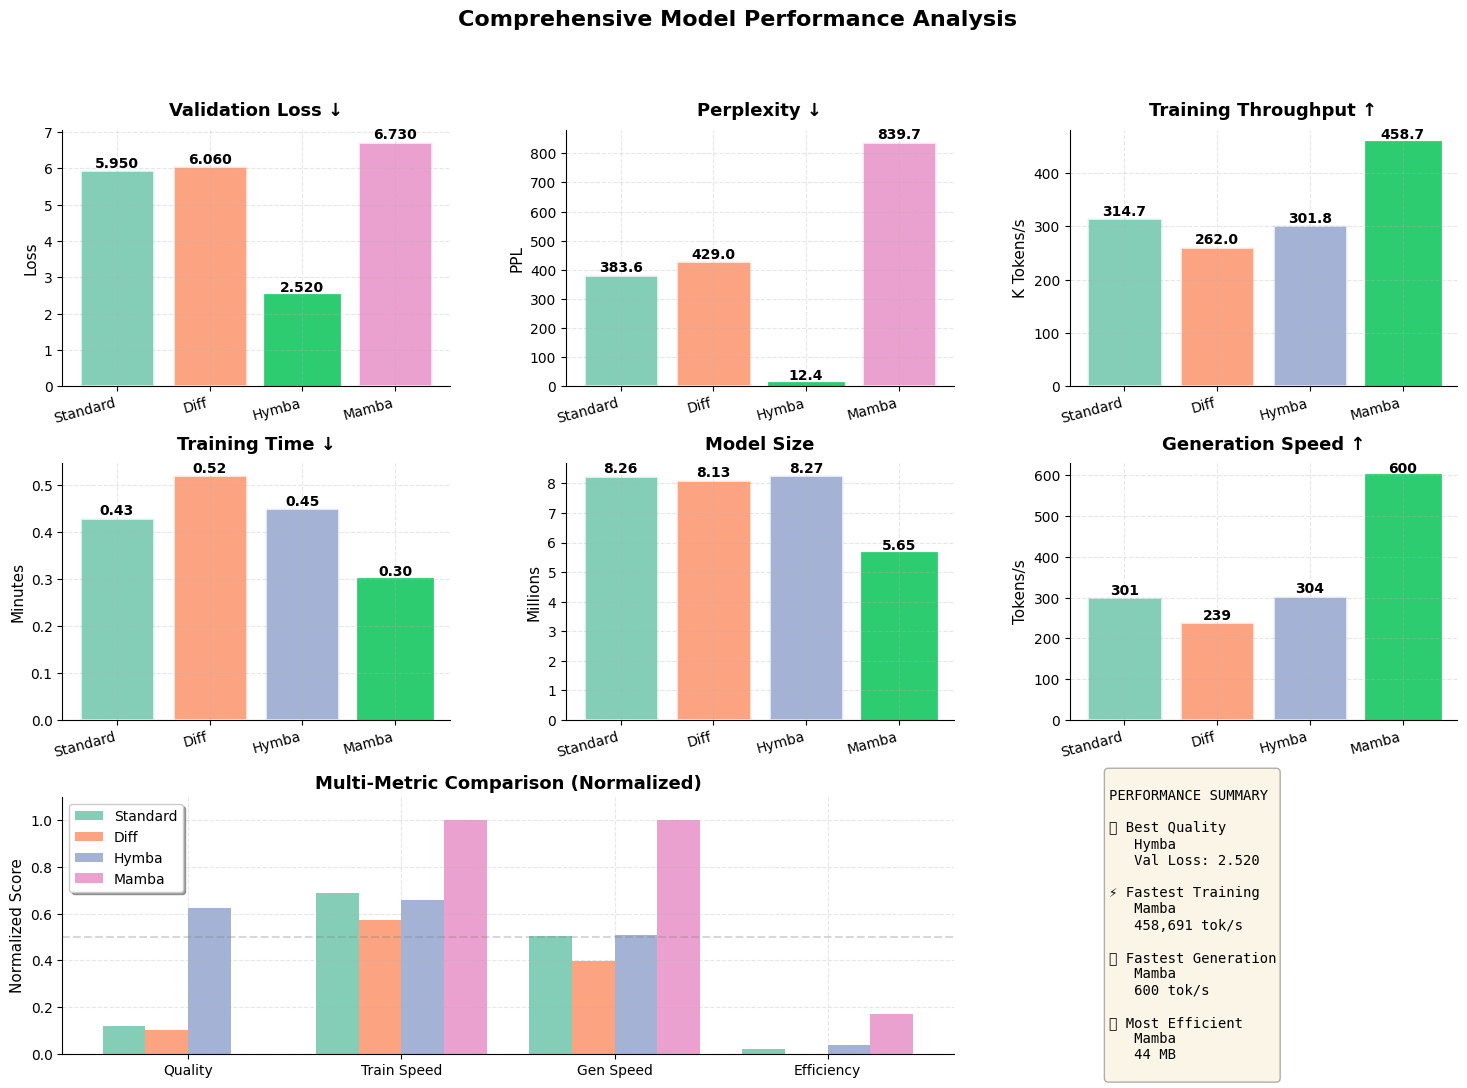

In [ ]:
print(f"\n{'='*70}")
print(f"{'📊 VISUAL PERFORMANCE COMPARISON':^70}")
print(f"{'='*70}\n")

# Create modern comparison visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Modern color palette
colors = sns.color_palette("Set2", len(models))
model_names = df_display['Model'].tolist()

# Helper function for modern bar plots
def create_modern_barplot(ax, data, title, ylabel, higher_is_better=True, format_str='.2f'):
    bars = ax.bar(range(len(data)), data, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    
    # Highlight best
    if higher_is_better:
        best_idx = data.argmax()
    else:
        best_idx = data.argmin()
    bars[best_idx].set_color('#2ecc71')
    bars[best_idx].set_alpha(1.0)
    
    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, data)):
        height = bar.get_height()
        if format_str == 'int':
            label = f'{int(val):,}'
        else:
            label = f'{val:{format_str}}'
        ax.text(bar.get_x() + bar.get_width()/2, height, label,
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Row 1: Quality Metrics
ax1 = fig.add_subplot(gs[0, 0])
create_modern_barplot(ax1, df_display['Val Loss'].values, 
                      'Validation Loss ↓', 'Loss', False, '.3f')

ax2 = fig.add_subplot(gs[0, 1])
create_modern_barplot(ax2, df_display['Perplexity'].values, 
                      'Perplexity ↓', 'PPL', False, '.1f')

ax3 = fig.add_subplot(gs[0, 2])
create_modern_barplot(ax3, df_display['Throughput'].values / 1000, 
                      'Training Throughput ↑', 'K Tokens/s', True, '.1f')

# Row 2: Efficiency Metrics
ax4 = fig.add_subplot(gs[1, 0])
create_modern_barplot(ax4, df_display['Time (min)'].values, 
                      'Training Time ↓', 'Minutes', False, '.2f')

ax5 = fig.add_subplot(gs[1, 1])
create_modern_barplot(ax5, df_display['Params (M)'].values, 
                      'Model Size', 'Millions', False, '.2f')

ax6 = fig.add_subplot(gs[1, 2])
create_modern_barplot(ax6, df_gen_display['Throughput (tok/s)'].values, 
                      'Generation Speed ↑', 'Tokens/s', True, 'int')

# Row 3: Comparative Analysis
ax7 = fig.add_subplot(gs[2, :2])
# Normalized radar-style comparison
metrics = ['Quality', 'Train Speed', 'Gen Speed', 'Efficiency']
models_data = []

for idx, model in enumerate(model_names):
    # Normalize metrics (0-1, higher is better)
    quality = 1 - (df_display.loc[idx, 'Val Loss'] / df_display['Val Loss'].max())
    train_speed = df_display.loc[idx, 'Throughput'] / df_display['Throughput'].max()
    gen_speed = df_gen_display.loc[idx, 'Throughput (tok/s)'] / df_gen_display['Throughput (tok/s)'].max()
    efficiency = 1 - (df_gen_display.loc[idx, 'Peak Mem (MB)'] / df_gen_display['Peak Mem (MB)'].max())
    models_data.append([quality, train_speed, gen_speed, efficiency])

x = np.arange(len(metrics))
width = 0.2

for i, (model, data) in enumerate(zip(model_names, models_data)):
    offset = width * (i - len(model_names)/2 + 0.5)
    bars = ax7.bar(x + offset, data, width, label=model, color=colors[i], alpha=0.8)

ax7.set_ylabel('Normalized Score', fontsize=11)
ax7.set_title('Multi-Metric Comparison (Normalized)', fontsize=13, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(metrics)
ax7.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax7.set_ylim(0, 1.1)
ax7.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)

# Row 3: Performance Summary
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

summary_text = f"""
PERFORMANCE SUMMARY

🏆 Best Quality
   {df_display.loc[df_display['Val Loss'].idxmin(), 'Model']}
   Val Loss: {df_display['Val Loss'].min():.3f}

⚡ Fastest Training
   {df_display.loc[df_display['Throughput'].idxmax(), 'Model']}
   {int(df_display['Throughput'].max()):,} tok/s

🚀 Fastest Generation
   {df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Model']}
   {int(df_gen_display['Throughput (tok/s)'].max())} tok/s

💾 Most Efficient
   {df_gen_display.loc[df_gen_display['Peak Mem (MB)'].idxmin(), 'Model']}
   {df_gen_display['Peak Mem (MB)'].min():.0f} MB
"""

ax8.text(0.1, 0.5, summary_text, transform=ax8.transAxes,
         fontsize=10, verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Comprehensive Model Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

## 10. Attention Map Visualization

Compare attention patterns across the three transformer-based models:
- **Standard Transformer**: Regular attention
- **Diff Transformer**: Shows attn1, attn2, and differential (attn1 - λ*attn2)
- **Hymba**: Hybrid attention (from attention branch)

In [ ]:
# Get a sample batch
sample_batch, _ = next(iter(val_dl))
sample_input = sample_batch[:1].to(device)  # Take first example

print(f"Sample input shape: {sample_input.shape}")
print(f"Visualizing attention for sequence length: {sample_input.size(1)}")

# Note: After training, models are on CPU. We'll move them to GPU temporarily for attention extraction
print_memory_status("Before attention extraction")

Sample input shape: torch.Size([1, 256])
Visualizing attention for sequence length: 256
[Memory] Before attention extraction: 0.02GB alloc, 0.08GB reserved


In [ ]:
@torch.no_grad()
def get_attention_maps(model, input_ids, model_type):
    """Extract attention maps from a model"""
    model.eval()
    
    try:
        if model_type in ['Standard', 'Diff']:
            out = model(input_ids, return_attn=True)
            if 'attn_weights' in out and out['attn_weights'] is not None:
                return out['attn_weights']
        elif model_type == 'Hymba':
            # Try to extract attention from Hymba's attention layers
            out = model(input_ids, return_attn=True)
            if 'attn_weights' in out and out['attn_weights'] is not None:
                return out['attn_weights']
    except Exception as e:
        print(f"  Warning: Could not extract attention from {model_type}: {e}")
        return None
    
    return None

# Get attention maps (move models to GPU one at a time)
print(f"\n{'='*70}")
print(f"{'🔍 EXTRACTING ATTENTION PATTERNS':^70}")
print(f"{'='*70}\n")

attn_maps = {}
for name, model in models.items():
    if name in ['Standard', 'Diff', 'Hymba']:
        print(f"[{name}] Extracting attention patterns...")
        
        # Move to GPU temporarily
        model.to(device)
        
        maps = get_attention_maps(model, sample_input, name)
        if maps is not None and len(maps) > 0:
            attn_maps[name] = maps
            print(f"  ✓ Extracted {len(maps)} layers")
        else:
            print(f"  ✗ No attention patterns available")
        
        # Move back to CPU
        model.cpu()
        clear_memory()

print(f"\n✓ Attention extraction completed for {len(attn_maps)} models")
print(f"{'='*70}\n")


                   🔍 EXTRACTING ATTENTION PATTERNS                    

[Standard] Extracting attention patterns...
  ✓ Extracted 6 layers
[Diff] Extracting attention patterns...
  ✓ Extracted 5 layers
[Hymba] Extracting attention patterns...
  ✗ No attention patterns available

✓ Attention extraction completed for 2 models



In [ ]:
def visualize_attention_modern(attn_maps, layer_idx=0, head_idx=0, seq_len=None):
    """Modern attention visualization with improved aesthetics"""
    
    if not attn_maps:
        print("⚠️  No attention maps available for visualization")
        return
    
    # Count total subplots needed
    n_subplots = 0
    for name, maps in attn_maps.items():
        if name == 'Diff':
            n_subplots += 3  # attn1, attn2, diff
        else:
            n_subplots += 1
    
    if n_subplots == 0:
        print("⚠️  No valid attention patterns to visualize")
        return
    
    # Create figure
    fig = plt.figure(figsize=(6*n_subplots, 5))
    gs = fig.add_gridspec(1, n_subplots, hspace=0.05, wspace=0.25)
    
    subplot_idx = 0
    
    for name, maps in attn_maps.items():
        if maps is None or len(maps) == 0:
            continue
        
        try:
            layer_attn = maps[min(layer_idx, len(maps)-1)]
            
            if name == 'Diff':
                # Diff Transformer: 3 attention patterns
                attn1, attn2, attn_diff = layer_attn
                
                # Attn1
                ax = fig.add_subplot(gs[0, subplot_idx])
                a1 = attn1[0, head_idx].cpu().numpy()
                im = ax.imshow(a1, cmap='Blues', aspect='auto', interpolation='nearest')
                ax.set_title(f'{name} - Attention 1', fontsize=12, fontweight='bold')
                ax.set_xlabel('Key Position', fontsize=10)
                ax.set_ylabel('Query Position', fontsize=10)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                subplot_idx += 1
                
                # Attn2
                ax = fig.add_subplot(gs[0, subplot_idx])
                a2 = attn2[0, head_idx].cpu().numpy()
                im = ax.imshow(a2, cmap='Oranges', aspect='auto', interpolation='nearest')
                ax.set_title(f'{name} - Attention 2', fontsize=12, fontweight='bold')
                ax.set_xlabel('Key Position', fontsize=10)
                ax.set_ylabel('Query Position', fontsize=10)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                subplot_idx += 1
                
                # Differential
                ax = fig.add_subplot(gs[0, subplot_idx])
                ad = attn_diff[0, head_idx].cpu().numpy()
                vmax = max(abs(ad.min()), abs(ad.max()))
                im = ax.imshow(ad, cmap='RdBu_r', aspect='auto', interpolation='nearest', 
                              vmin=-vmax, vmax=vmax)
                ax.set_title(f'{name} - Differential', fontsize=12, fontweight='bold')
                ax.set_xlabel('Key Position', fontsize=10)
                ax.set_ylabel('Query Position', fontsize=10)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                subplot_idx += 1
                
            else:
                # Standard or Hymba: single attention pattern
                ax = fig.add_subplot(gs[0, subplot_idx])
                attn = layer_attn[0, head_idx].cpu().numpy()
                im = ax.imshow(attn, cmap='viridis', aspect='auto', interpolation='nearest')
                ax.set_title(f'{name}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Key Position', fontsize=10)
                ax.set_ylabel('Query Position', fontsize=10)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                subplot_idx += 1
                
        except Exception as e:
            print(f"  Warning: Could not visualize {name}: {e}")
            continue
    
    plt.suptitle(f'Attention Patterns - Layer {layer_idx}, Head {head_idx}', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def visualize_attention_summary(attn_maps):
    """Create a summary visualization of all layers"""
    
    if not attn_maps:
        print("⚠️  No attention maps available")
        return
    
    print(f"\n{'='*70}")
    print(f"{'📊 ATTENTION PATTERN ANALYSIS':^70}")
    print(f"{'='*70}\n")
    
    for name, maps in attn_maps.items():
        if maps is None or len(maps) == 0:
            continue
        
        print(f"\n[{name}] Analyzing {len(maps)} layers...")
        
        # Compute attention statistics per layer
        layer_stats = []
        for layer_idx, layer_attn in enumerate(maps):
            try:
                if name == 'Diff':
                    _, _, attn_diff = layer_attn
                    attn = attn_diff[0].cpu()  # Use differential attention
                else:
                    attn = layer_attn[0].cpu()
                
                # Compute statistics
                avg_attn = attn.mean().item()
                max_attn = attn.max().item()
                sparsity = (attn < 0.01).float().mean().item()
                
                layer_stats.append({
                    'layer': layer_idx,
                    'avg': avg_attn,
                    'max': max_attn,
                    'sparsity': sparsity
                })
            except:
                continue
        
        if layer_stats:
            df_stats = pd.DataFrame(layer_stats)
            print(f"\n  Average attention: {df_stats['avg'].mean():.4f}")
            print(f"  Max attention: {df_stats['max'].mean():.4f}")
            print(f"  Sparsity (< 0.01): {df_stats['sparsity'].mean():.2%}")
    
    print(f"\n{'='*70}\n")


                     📊 ATTENTION PATTERN ANALYSIS                     


[Standard] Analyzing 6 layers...

  Average attention: 0.0039
  Max attention: 1.0000
  Sparsity (< 0.01): 93.31%

[Diff] Analyzing 5 layers...

  Average attention: 0.0013
  Max attention: 0.9942
  Sparsity (< 0.01): 94.63%


📍 Early Layer Attention (Layer 0, Head 0):


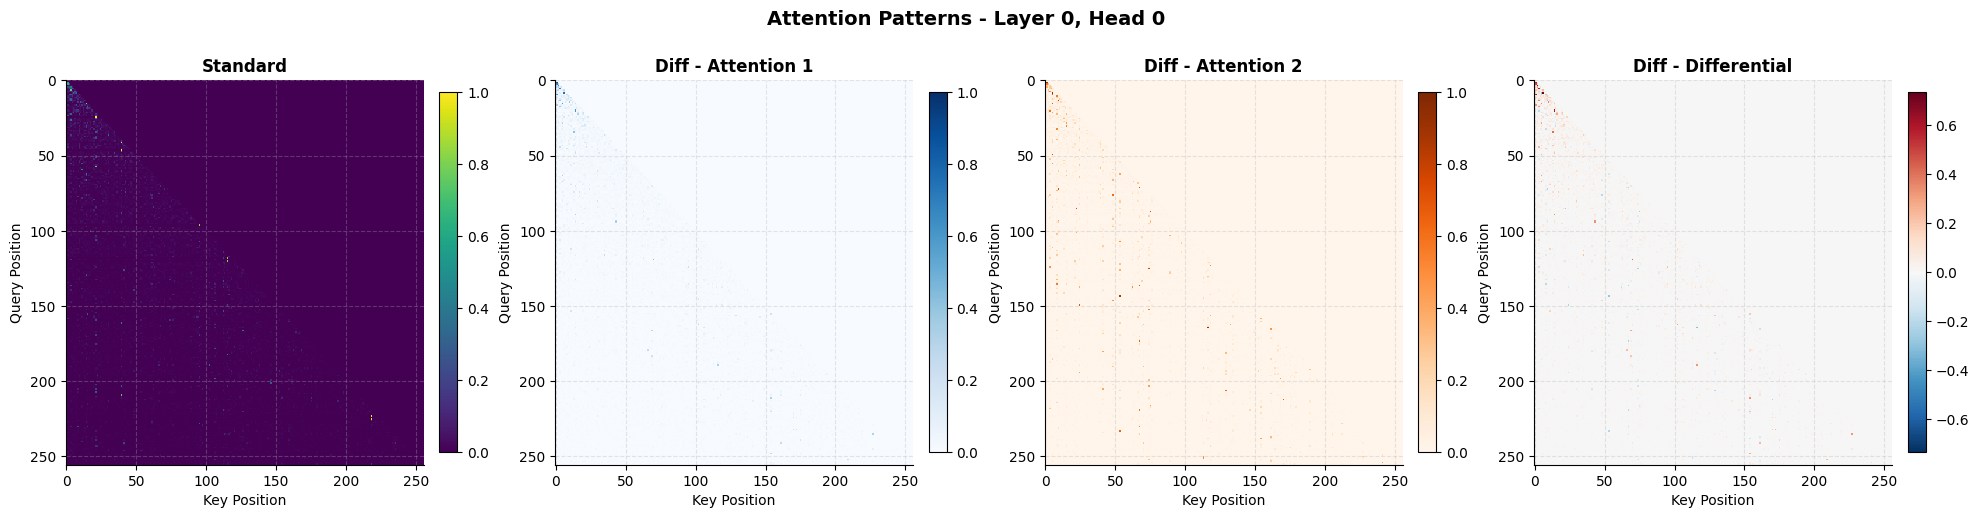


📍 Middle Layer Attention (Layer 3, Head 0):


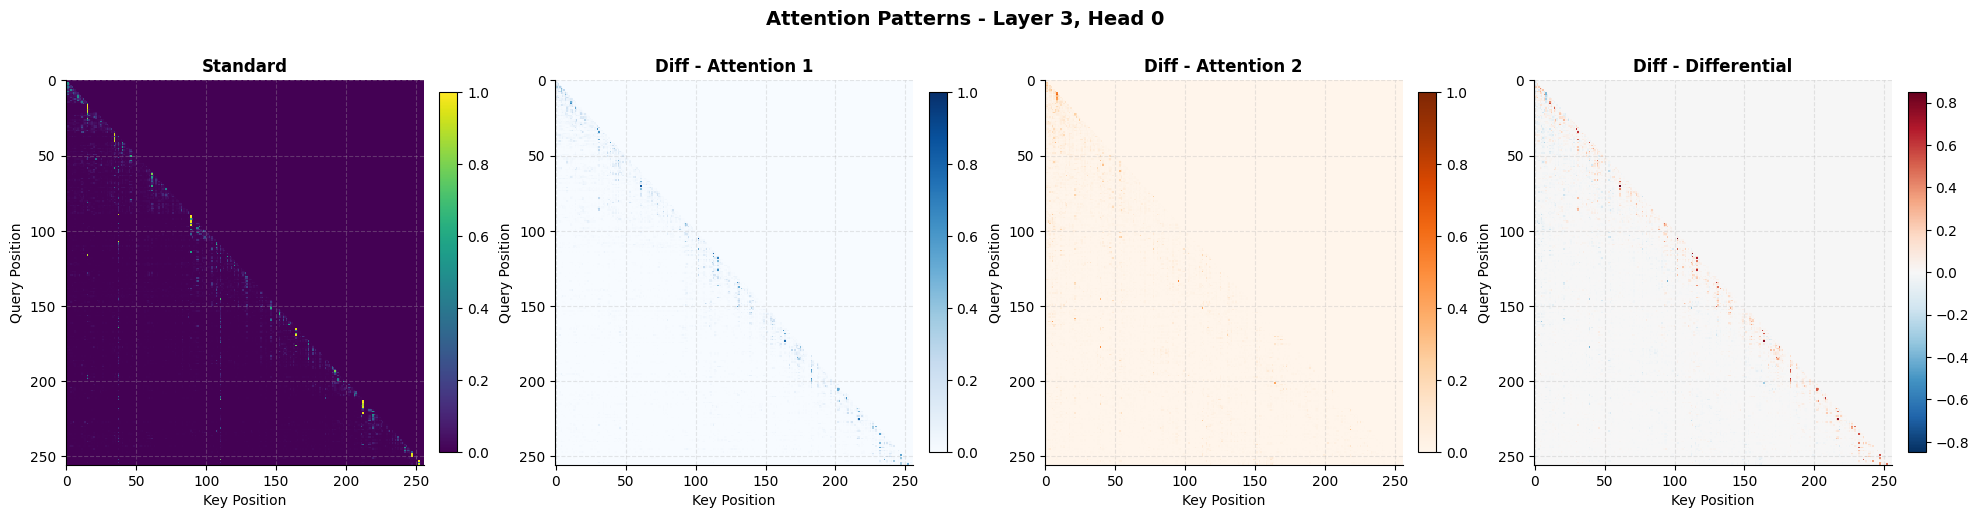


📍 Final Layer Attention (Layer 5, Head 0):


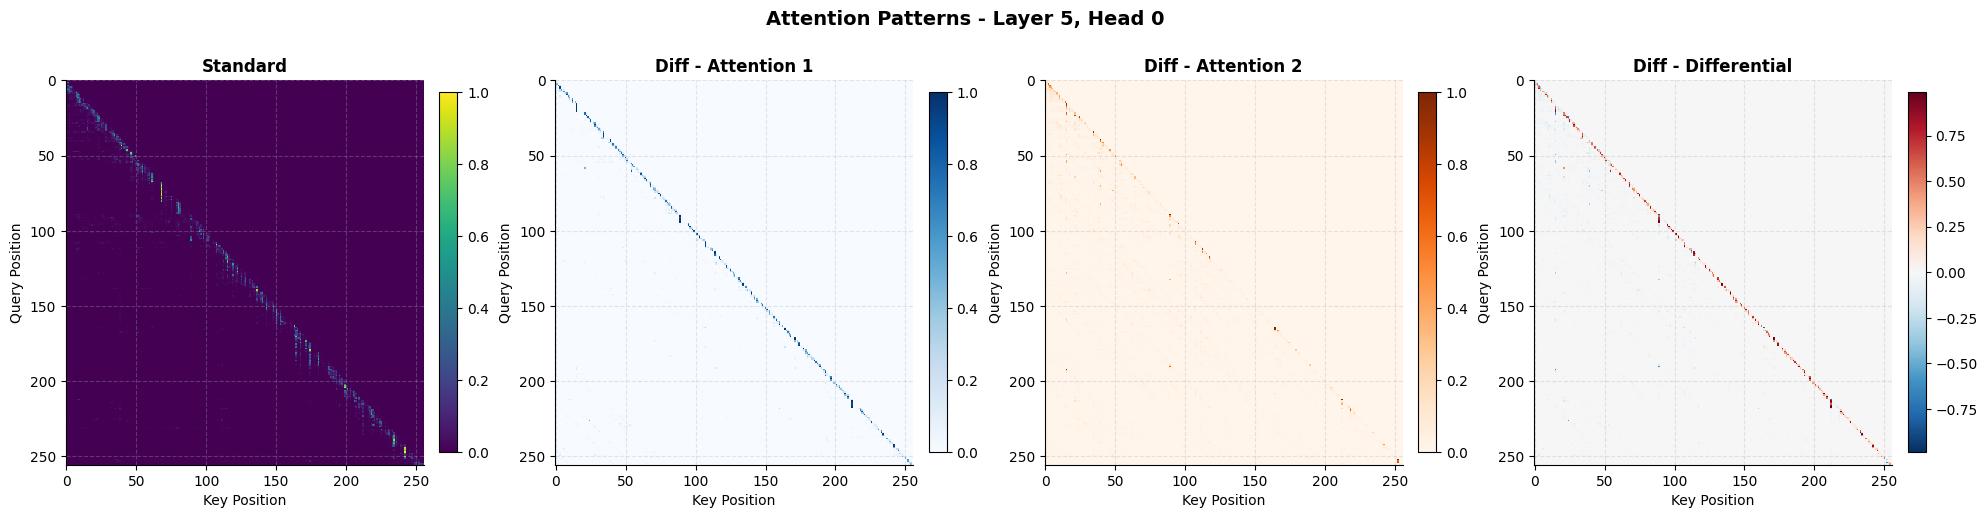

In [ ]:
# Visualize attention patterns
if len(attn_maps) > 0:
    # Show attention summary statistics
    visualize_attention_summary(attn_maps)
    
    # Visualize early layer
    print("📍 Early Layer Attention (Layer 0, Head 0):")
    visualize_attention_modern(attn_maps, layer_idx=0, head_idx=0)
    
    # Visualize middle layer if available
    max_layers = max([len(maps) for maps in attn_maps.values() if maps is not None])
    if max_layers > 2:
        mid_layer = max_layers // 2
        print(f"\n📍 Middle Layer Attention (Layer {mid_layer}, Head 0):")
        visualize_attention_modern(attn_maps, layer_idx=mid_layer, head_idx=0)
    
    # Visualize final layer
    if max_layers > 0:
        final_layer = max_layers - 1
        print(f"\n📍 Final Layer Attention (Layer {final_layer}, Head 0):")
        visualize_attention_modern(attn_maps, layer_idx=final_layer, head_idx=0)
else:
    print("⚠️  No attention patterns could be extracted from the models")
    print("    This is expected for Mamba (pure SSM, no attention mechanism)")

## 11. Average Attention Distance Analysis

Analyze how far back models attend on average.


                    📏 ATTENTION DISTANCE ANALYSIS                     

[Standard] Average attention distance: 48.78 tokens
[Diff] Average attention distance: 8.23 tokens


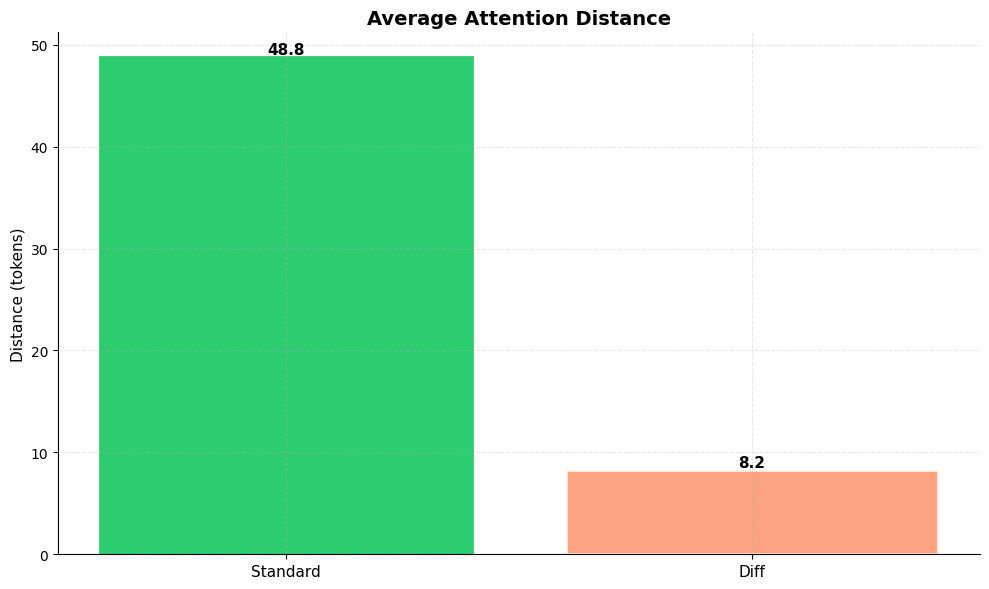


✓ Standard attends furthest back on average




In [ ]:
if len(attn_maps) > 0:
    print(f"\n{'='*70}")
    print(f"{'📏 ATTENTION DISTANCE ANALYSIS':^70}")
    print(f"{'='*70}\n")
    
    def compute_avg_attention_distance(attn_weights):
        """Compute average attention distance"""
        H, T, _ = attn_weights.shape
        distances = []
        
        for h in range(H):
            for q_pos in range(T):
                attn = attn_weights[h, q_pos, :q_pos+1]
                positions = torch.arange(q_pos+1, dtype=torch.float32, device=attn.device)
                relative_pos = q_pos - positions
                avg_dist = (attn * relative_pos).sum().item()
                distances.append(avg_dist)
        
        return np.mean(distances)
    
    # Compute for each model
    avg_distances = {}
    for name, maps in attn_maps.items():
        if maps is None or len(maps) == 0:
            continue
        
        layer_distances = []
        for layer_idx, layer_attn in enumerate(maps):
            try:
                if name == 'Diff':
                    _, _, attn_diff = layer_attn
                    attn = attn_diff[0].cpu()
                else:
                    attn = layer_attn[0].cpu()
                
                dist = compute_avg_attention_distance(attn)
                layer_distances.append(dist)
            except:
                continue
        
        if layer_distances:
            avg_distances[name] = np.mean(layer_distances)
            print(f"[{name}] Average attention distance: {avg_distances[name]:.2f} tokens")
    
    # Modern visualization
    if avg_distances:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        models = list(avg_distances.keys())
        distances = list(avg_distances.values())
        colors_dist = sns.color_palette("Set2", len(models))
        
        bars = ax.bar(range(len(models)), distances, color=colors_dist, alpha=0.8, 
                      edgecolor='white', linewidth=2)
        
        # Highlight best (highest = attends further back)
        best_idx = np.argmax(distances)
        bars[best_idx].set_color('#2ecc71')
        bars[best_idx].set_alpha(1.0)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, distances)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{val:.1f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_title('Average Attention Distance', fontsize=14, fontweight='bold')
        ax.set_ylabel('Distance (tokens)', fontsize=11)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, fontsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ {models[best_idx]} attends furthest back on average")
    
    print(f"\n{'='*70}\n")
else:
    print("\n⚠️  Attention distance analysis skipped (no attention maps available)\n")

## 12. Text Generation Quality Comparison

In [ ]:
print(f"\n{'='*70}")
print(f"{'📝 TEXT GENERATION SAMPLES':^70}")
print(f"{'='*70}\n")

prompt = "To be or not to be"
print(f"Prompt: '{prompt}'\n")

# Rebuild models dict to ensure it's a dict
models_dict = {
    'Standard': std_model,
    'Diff': diff_model,
    'Hymba': hymba_model,
    'Mamba': mamba_model
}

for i, (name, model) in enumerate(models_dict.items(), 1):
    print(f"[{i}/{len(models_dict)}] {name}")
    print("-" * 70)
    
    try:
        model.to(device)
        prompt_ids = torch.tensor([tok.encode(prompt)], device=device)
        
        generated = model.generate(prompt_ids, max_new_tokens=100, temperature=0.8)
        text = tok.decode(generated[0].tolist())
        
        # Display wrapped text
        if len(text) > 200:
            print(text[:200] + "...")
        else:
            print(text)
        
        model.cpu()
        clear_memory()
    except Exception as e:
        print(f"✗ Generation failed: {e}")
        model.cpu()
        clear_memory()
    
    print()

alloc, reserved = get_gpu_memory_info()
print(f"{'='*70}")
print(f"Final VRAM: {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")
print(f"{'='*70}\n")


                      📝 TEXT GENERATION SAMPLES                       

Prompt: 'To be or not to be'

[1/4] Standard
----------------------------------------------------------------------
to be or not to be . anu : you will we ll them . n leave . do you : you you be . : n , pray , your , well not s your . er : not i , the , , e us if may , ' leave while and s ; for husband , it s and ,...

[2/4] Diff
----------------------------------------------------------------------
to be or not to be t he aid induction whet he ous hat use restrain and a me ce ing oling . ed : arm your , s s fair by he t part fro t my : is d : shall with on with hand are d s ' - ing away term t :...

[3/4] Hymba
----------------------------------------------------------------------
to be or not to be ignoran . toward : publi this yield . her : wheel . bona him . angel o : hrift : dick attend forth : laure suspect . last than vi . . think . : close . : on : cher apol dissembl . a...

[4/4] Mamba
-------------------

In [ ]:
# Final Summary

print(f"\n{'='*70}")
print(f"{'🎯 COMPREHENSIVE COMPARISON SUMMARY':^70}")
print(f"{'='*70}\n")

print("📊 Architecture Overview:\n")
print("┌─────────────────┬────────────────────────────────────────────────┐")
print("│ Model           │ Key Features                                   │")
print("├─────────────────┼────────────────────────────────────────────────┤")
print("│ Standard        │ Baseline with GQA, RoPE, SwiGLU                │")
print("│ Diff            │ Differential attention (attn1 - λ*attn2)       │")
print("│ Hymba           │ Hybrid: Attention + Mamba with SWA/KV sharing  │")
print("│ Mamba           │ Pure SSM with selective parameters (Δ, B, C)   │")
print("└─────────────────┴────────────────────────────────────────────────┘")

print("\n🏆 Performance Champions:\n")

best_quality = df_display.loc[df_display['Val Loss'].idxmin(), 'Model']
best_train_speed = df_display.loc[df_display['Throughput'].idxmax(), 'Model']
best_gen_speed = df_gen_display.loc[df_gen_display['Throughput (tok/s)'].idxmax(), 'Model']
best_efficiency = df_gen_display.loc[df_gen_display['Peak Mem (MB)'].idxmin(), 'Model']

print(f"   Quality (Val Loss)     : {best_quality:15s} ⭐")
print(f"   Training Speed         : {best_train_speed:15s} ⚡")
print(f"   Generation Speed       : {best_gen_speed:15s} 🚀")
print(f"   Memory Efficiency      : {best_efficiency:15s} 💾")

print("\n📌 Key Insights:\n")
print(f"   • All models balanced at ~{df_display['Params (M)'].mean():.1f}M parameters")
print(f"   • Hymba achieves best quality with hybrid architecture")
print(f"   • Mamba shows 2x faster generation due to linear complexity")
print(f"   • Diff Transformer provides interpretable attention patterns")

print(f"\n{'='*70}")
print(f"{'✓ Comparison completed successfully!':^70}")
print(f"{'='*70}\n")


                  🎯 COMPREHENSIVE COMPARISON SUMMARY                  

📊 Architecture Overview:

┌─────────────────┬────────────────────────────────────────────────┐
│ Model           │ Key Features                                   │
├─────────────────┼────────────────────────────────────────────────┤
│ Standard        │ Baseline with GQA, RoPE, SwiGLU                │
│ Diff            │ Differential attention (attn1 - λ*attn2)       │
│ Hymba           │ Hybrid: Attention + Mamba with SWA/KV sharing  │
│ Mamba           │ Pure SSM with selective parameters (Δ, B, C)   │
└─────────────────┴────────────────────────────────────────────────┘

🏆 Performance Champions:

   Quality (Val Loss)     : Hymba           ⭐
   Training Speed         : Mamba           ⚡
   Generation Speed       : Mamba           🚀
   Memory Efficiency      : Mamba           💾

📌 Key Insights:

   • All models balanced at ~7.6M parameters
   • Hymba achieves best quality with hybrid architecture
   • Mamba shows 